In [4]:
import os
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import fm2p

Loading DLC 2.3.7...
DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)


c:\Users\dmartins\anaconda3\envs\fm1\lib\site-packages\oasis\functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


In [ ]:
cfg = r'K:\Mini2P\250220_DMM_DMM042_pillar\preprocessed_config.yaml'
rname = 'fm1'

if type(cfg)==str:
    with open(cfg, 'r') as infile:
        cfg = yaml.load(infile, Loader=yaml.FullLoader)
rcfg = cfg[rname]

rpath = rcfg['rpath']
eye_data = fm2p.read_h5(rcfg['eye_preproc_path'])
top_data = fm2p.read_h5(rcfg['top_preproc_path'])
twop_data = fm2p.read_h5(rcfg['twop_preproc_path'])
eyeT_startInd = rcfg['eyeT_startInd']
eyeT_endInd = rcfg['eyeT_endInd']

# Two photon data
sps = twop_data['s2p_spks']
raw_dFF = twop_data['raw_dFF']
twop_dt = 1./cfg['twop_rate']
twopT = np.arange(0, np.size(sps, 1)*twop_dt, twop_dt)

# Eyecam data
eyeT = eye_data['eyeT'][eyeT_startInd:eyeT_endInd]
theta_raw = eye_data['theta'][eyeT_startInd:eyeT_endInd]
phi_raw = eye_data['phi'][eyeT_startInd:eyeT_endInd]
puprad_raw = eye_data['longaxis'][eyeT_startInd:eyeT_endInd]

# Interpolate eyecam data to twop and topdown data
eyeT = eyeT.copy() - eyeT[0]

theta = fm2p.interpT(theta_raw, eyeT, twopT, fill_consecutive=True)
phi = fm2p.interpT(phi_raw, eyeT, twopT, fill_consecutive=True)
puprad = fm2p.interpT(puprad_raw, eyeT, twopT, fill_consecutive=True)

# Topcam data
pxls2cm = top_data['pxls2cm']
speed = top_data['speed']
# Animal yaw is defined so that 0 deg is rightward in the raw video, 90 deg is downward in the raw
# video, and angles wrap from 0 to 360 deg clockwise.
yaw = top_data['head_yaw_deg']
movement_yaw = top_data['movement_yaw_deg']
top_x = top_data['x']
top_y = top_data['y']
top_xdisp = top_data['x_displacement']
top_ydisp = top_data['y_displacement']
learx = top_data['lear_x']
leary = top_data['lear_y']
rearx = top_data['rear_x']
reary = top_data['rear_y']
arenaTL = (top_data['arenaTL']['x'], top_data['arenaTL']['y'])
arenaTR = (top_data['arenaTR']['x'], top_data['arenaTR']['y'])
arenaBL = (top_data['arenaBL']['x'], top_data['arenaBL']['y'])
arenaBR = (top_data['arenaBR']['x'], top_data['arenaBR']['y'])
pillarT = (top_data['pillarT']['x'], top_data['pillarT']['y'])
pillarB = (top_data['pillarB']['x'], top_data['pillarB']['y'])
pillarL = (top_data['pillarL']['x'], top_data['pillarL']['y'])
pillarR = (top_data['pillarR']['x'], top_data['pillarR']['y'])
pillar_radius = top_data['pillar_radius']
pillar_centroid = (top_data['pillar_centroid']['x'], top_data['pillar_centroid']['y'])


In [225]:
top_data.keys()

dict_keys(['arenaBL', 'arenaBR', 'arenaTL', 'arenaTR', 'head_yaw', 'head_yaw_deg', 'lear_x', 'lear_y', 'movement_yaw', 'movement_yaw_deg', 'pillarB', 'pillarL', 'pillarR', 'pillarT', 'pillar_centroid', 'pillar_radius', 'pxls2cm', 'rear_x', 'rear_y', 'speed', 'video', 'x', 'x_displacement', 'y', 'y_displacement'])

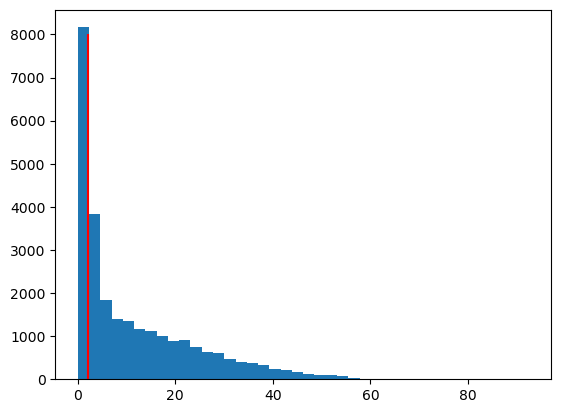

In [170]:
plt.hist(speed, bins=40)
plt.vlines(2, 0, 8000, 'r')

In [166]:
np.sum(speed>2) / len(speed)

0.6328877629254308

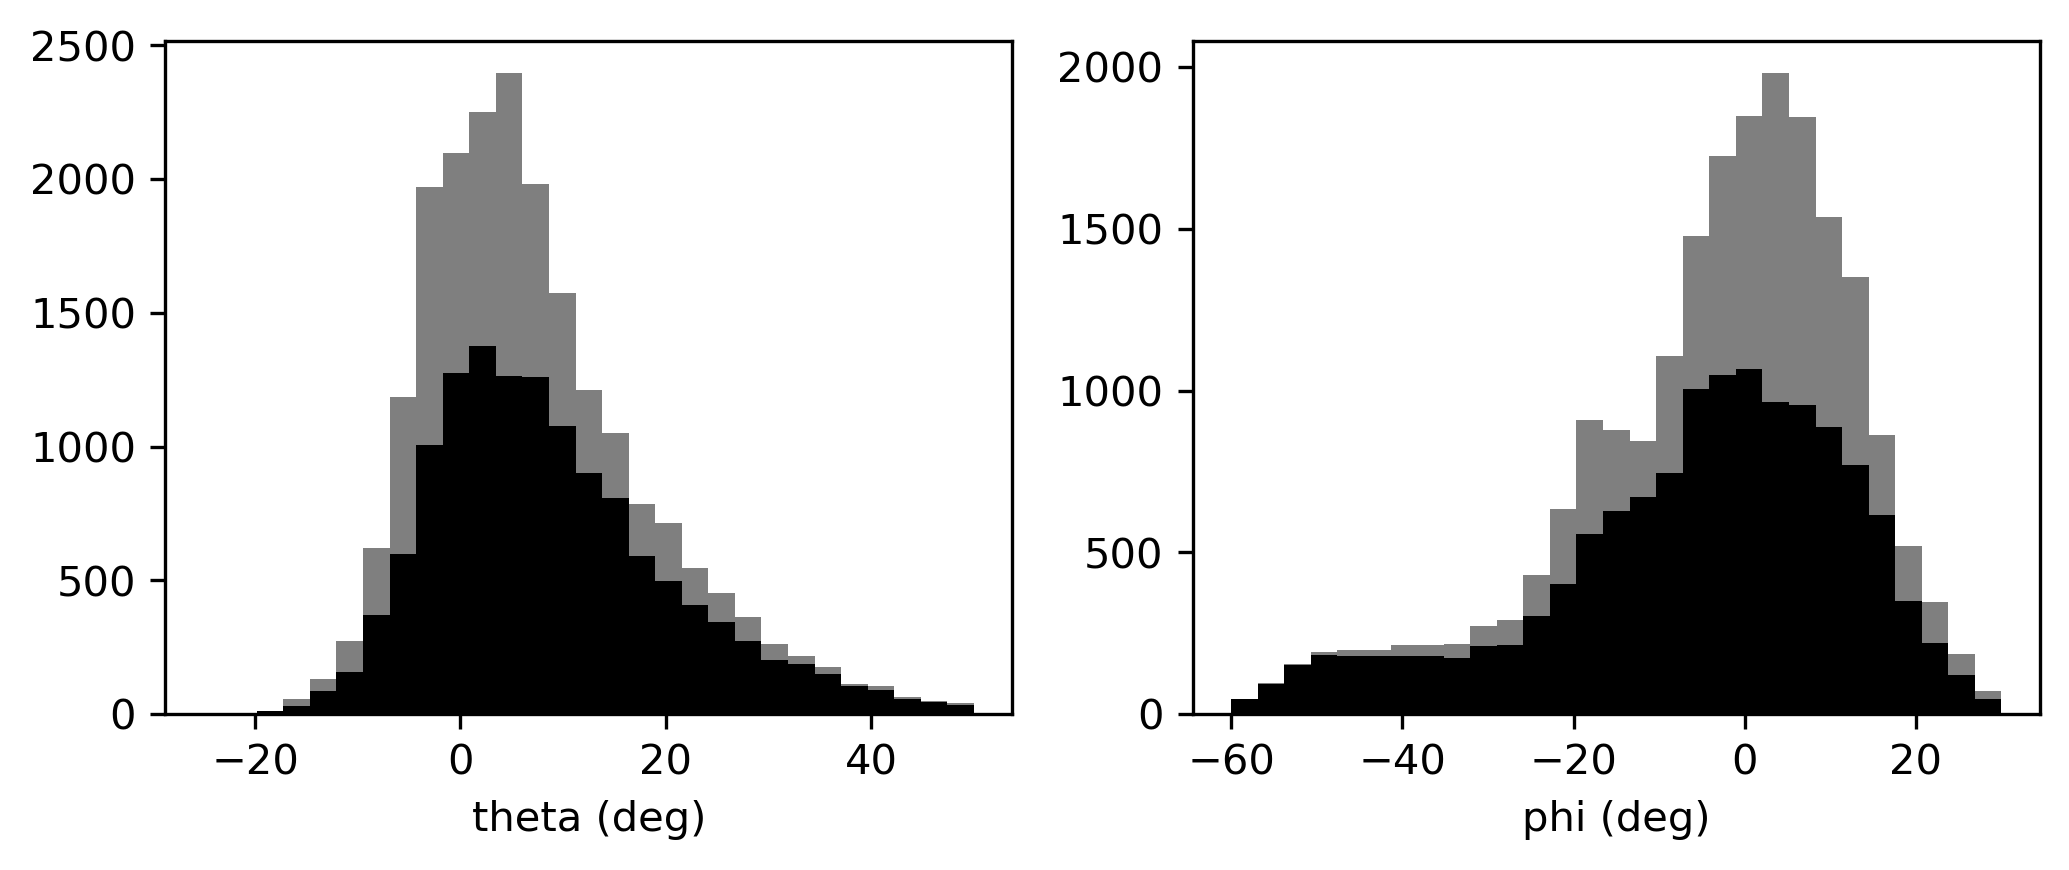

In [209]:
fig, [ax1,ax2] = plt.subplots(1, 2, dpi=300, figsize=(7,3))

ax1.hist(np.rad2deg(theta), color='k', alpha=0.5, bins=np.linspace(-25, 50, 30))
ax1.hist(np.rad2deg(theta[:-1][speed>=2.]), color='k', bins=np.linspace(-25, 50, 30))

ax2.hist(np.rad2deg(phi), color='k', alpha=0.5, bins=np.linspace(-60, 30, 30))
ax2.hist(np.rad2deg(phi[:-1][speed>=2.]), color='k', bins=np.linspace(-60, 30, 30))

ax1.set_xlabel('theta (deg)')
ax2.set_xlabel('phi (deg)')

fig.tight_layout()

In [211]:
vid = fm2p.pack_video_frames(r'K:\Mini2P\250220_DMM_DMM042_pillar\fm1\rec2_0001.mp4', dwnsmpl=0.25)

Reading rec2_0001.mp4


100%|██████████| 30000/30000 [06:03<00:00, 82.62it/s]


In [216]:
import cv2
from tqdm import tqdm

In [227]:
vid_save_path = 'demo_topdown_video_2.avi'

scale = 0.25
start = 1000
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out_vid = cv2.VideoWriter(vid_save_path, fourcc, 7.5, (640, 480))
maxprev = 25

plot_yaw = np.deg2rad(yaw)

for f in tqdm(range(start,start+3600)):

    fig = plt.figure()

    plt.imshow(vid[f,:,:].astype(np.uint8), cmap='gray')
    plt.axis('off')

    plt.plot(learx[f]*scale, leary[f]*scale, 'o', color='tab:green')
    plt.plot(rearx[f]*scale, reary[f]*scale, 'o', color='tab:red')

    plt.plot([top_x[f]*scale, (top_x[f]*scale)+30*np.cos(plot_yaw[f])],
             [top_y[f]*scale,(top_y[f]*scale)+30*np.sin(plot_yaw[f])],
             '-', linewidth=2, color='tab:purple')
    
    # for p in range(maxprev):

    #     prevf = f - p
    #     plt.plot(top_x[prevf]*scale, top_y[prevf]*scale,
    #              'o', color='tab:purple',
    #              alpha=(maxprev-p)/maxprev) # neck position history
    
    # plt.arrow(top_x[f]*scale, top_y[f]*scale,
    #             top_xdisp[f], top_ydisp[f],
    #             color='tab:green', width=1)
    
    # Save the frame out
    fig.canvas.draw()
    frame_as_array = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    frame_as_array = frame_as_array.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close()

    img = cv2.cvtColor(frame_as_array, cv2.COLOR_RGB2BGR)
    out_vid.write(img.astype('uint8'))

out_vid.release()

  0%|          | 0/3600 [00:00<?, ?it/s]C:\Users\dmartins\AppData\Local\Temp\ipykernel_19788\3682227992.py:38: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  frame_as_array = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
C:\Users\dmartins\AppData\Local\Temp\ipykernel_19788\3682227992.py:38: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  frame_as_array = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
100%|██████████| 3600/3600 [02:06<00:00, 28.43it/s] 


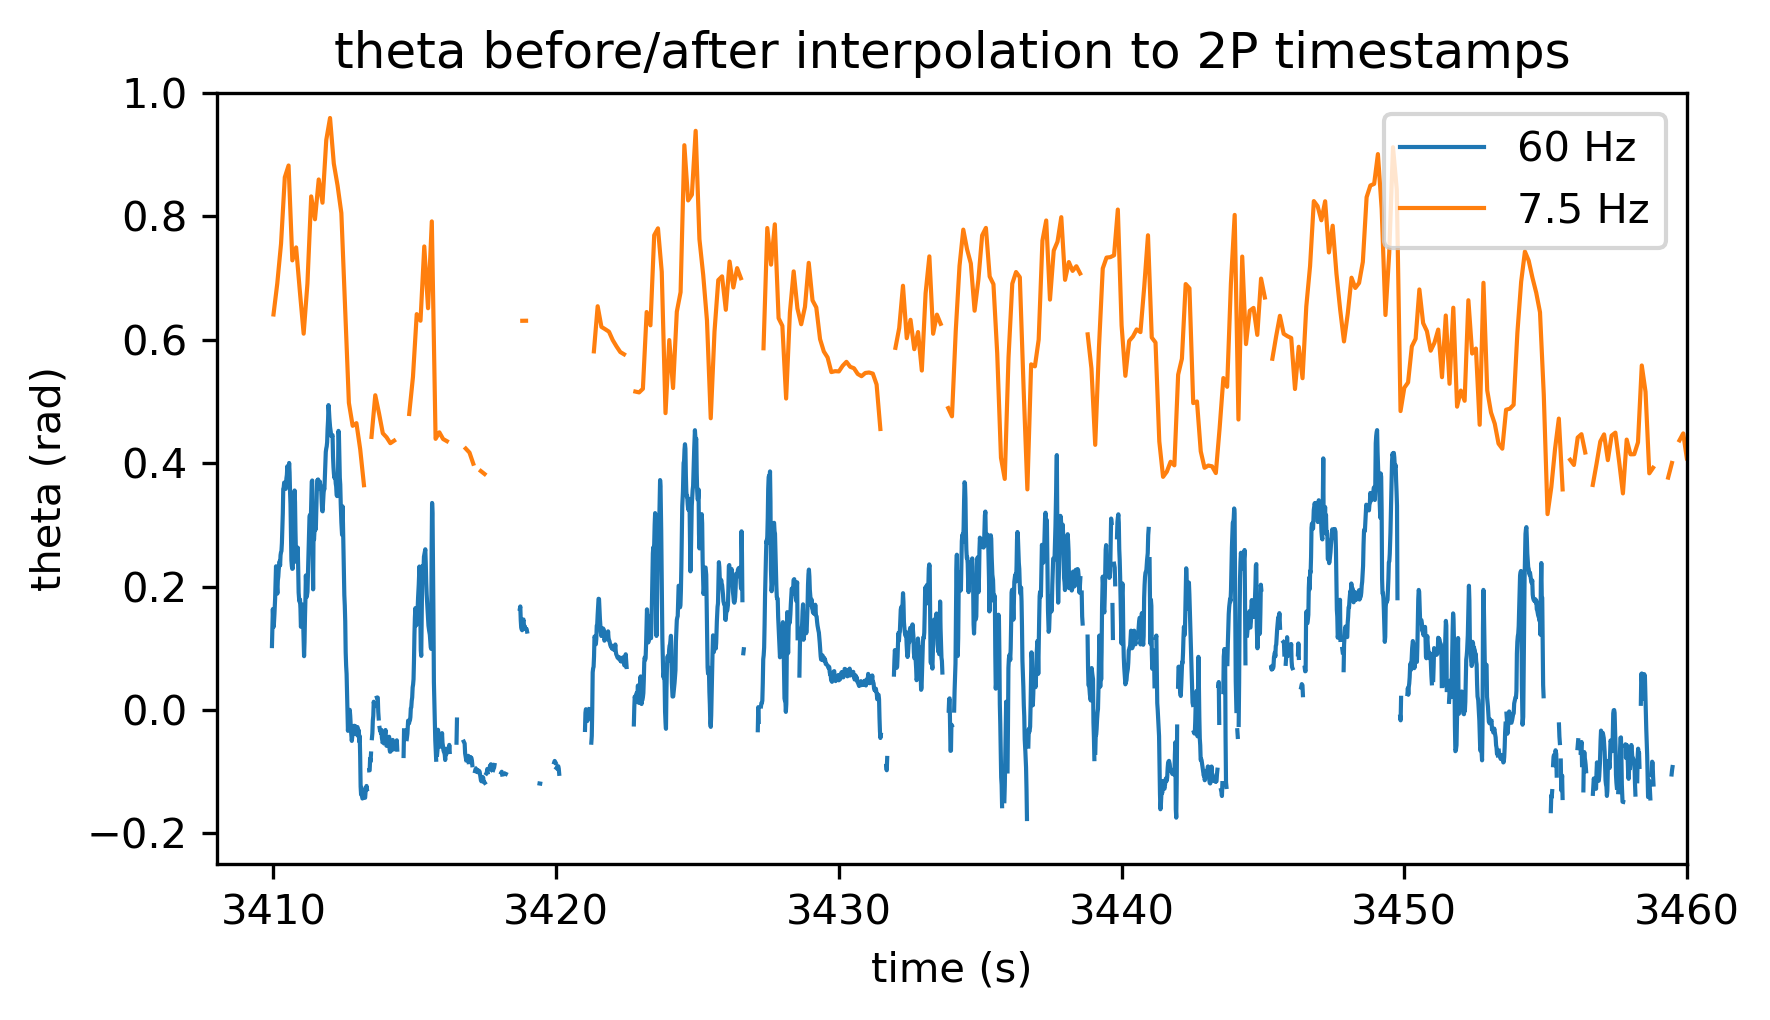

In [17]:
plt.figure(dpi=300, figsize=(6,3.5))
plt.plot(eyeT, theta_raw, lw=1, label='60 Hz')
plt.plot(twopT, theta+0.5, lw=1, label='7.5 Hz')
plt.xlim([3408, 3460])
plt.ylim([-.25,1])
plt.legend(loc='upper right')
plt.xlabel('time (s)')
plt.ylabel('theta (rad)')
plt.title('theta before/after interpolation to 2P timestamps')
plt.tight_layout()

In [20]:
dist_to_pillar = np.zeros_like(top_x) * np.nan
angle_to_pillar = np.zeros_like(top_x) * np.nan
angle_pillar_spans = np.zeros_like(top_x) * np.nan
for f in range(len(top_x)):

    # All geometry is handled using units of radians for angles and units of pixels for distances

    a_ = pillar_centroid[1] - top_y[f]
    b_ = pillar_centroid[0] - top_x[f]

    dist_to_pillar[f] = np.sqrt(b_**2 + a_**2)
    angle_to_pillar[f] = np.tan(a_ / b_) # rad
    
    # Angle that pillar spans given the animal's current distance
    angle_pillar_spans[f] = np.tan(pillar_radius / dist_to_pillar[f]) # rad

    # Horizontal gaze angle relative to the animal's head (instead of relative to the central axis
    # of the camera).
    theta_reltohead = theta[f] + cfg['eyecam_angular_offset']

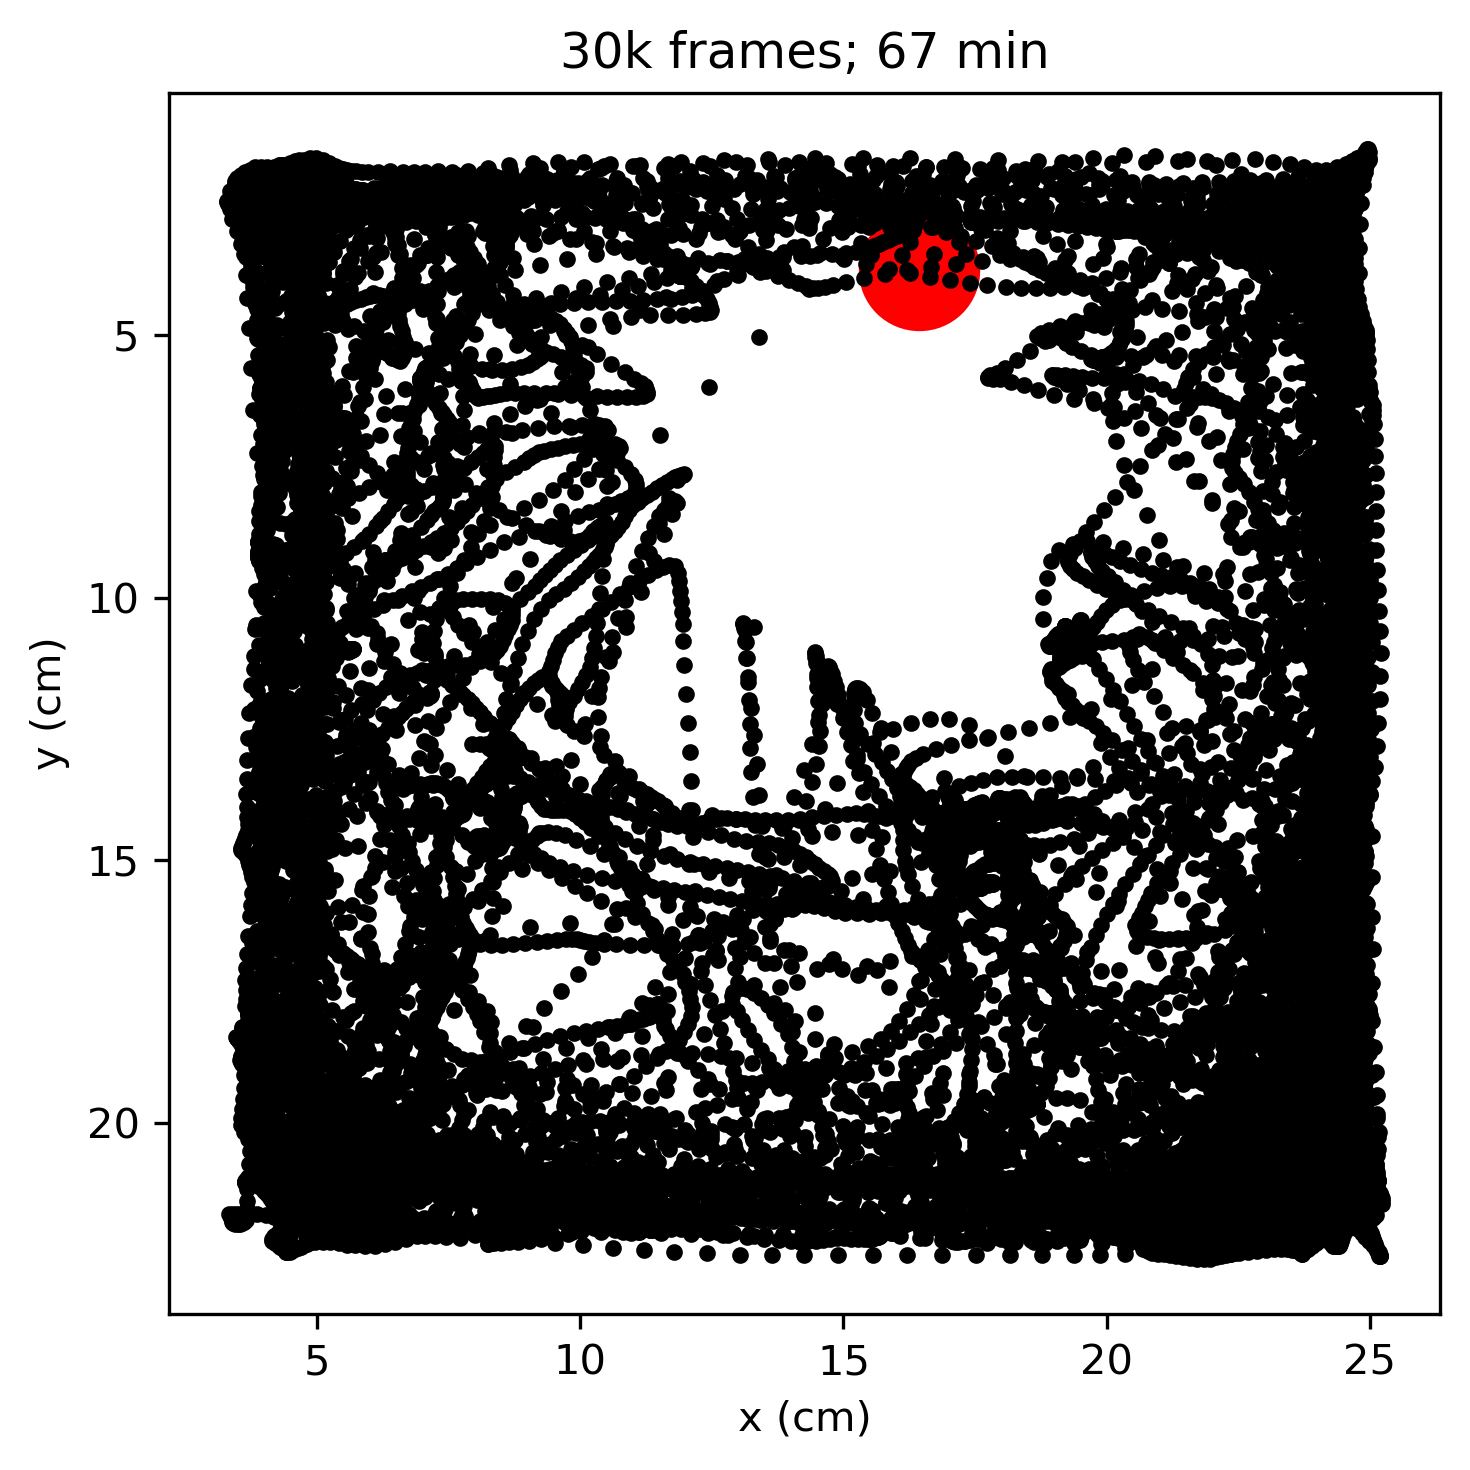

In [ ]:
circle1 = plt.Circle(pillar_centroid/pxls2cm, pillar_radius/pxls2cm, color='r')
fig, ax = plt.subplots(1, 1, figsize=(5,5), dpi=300)
ax.invert_yaxis()
ax.plot(top_x/pxls2cm, top_y/pxls2cm, '.', color='k')
ax.set_title('30k frames; 67 min')
ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
ax.add_patch(circle1)
fig.tight_layout()

In [101]:
def frac_good(x):
    return np.sum(~np.isnan(x)) / len(x)

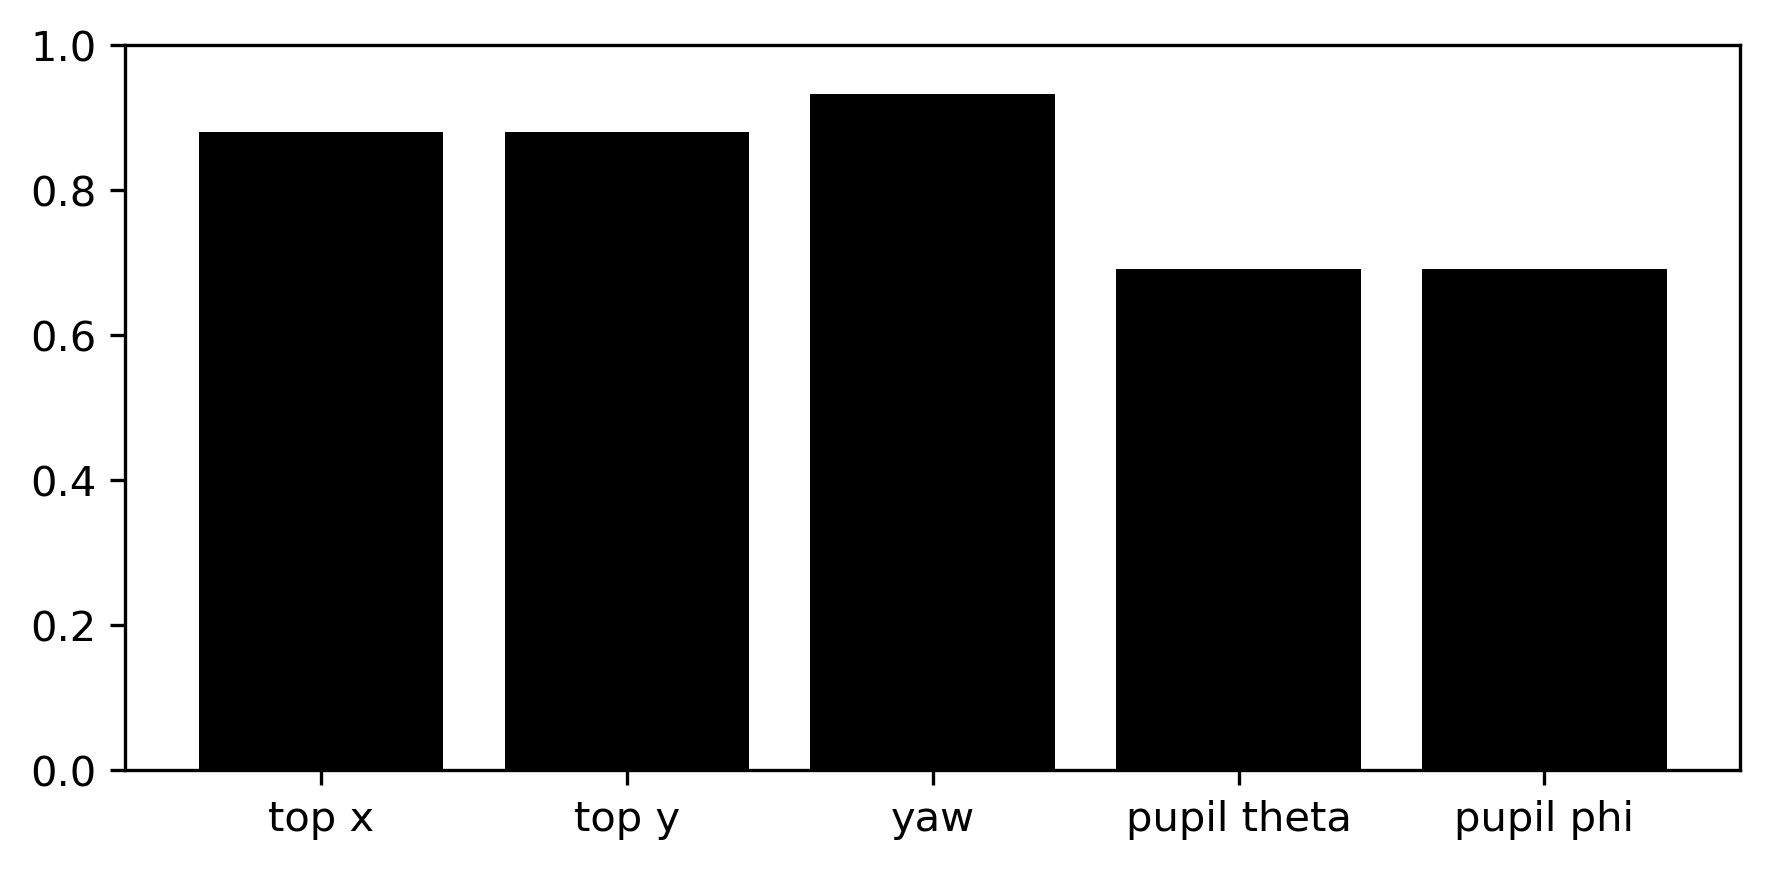

In [116]:
fig, ax = plt.subplots(1,1, dpi=300, figsize=(6,3))
ax.bar(0, frac_good(top_x), color='k')
ax.bar(1, frac_good(top_y), color='k')
ax.bar(2, frac_good(yaw), color='k')
ax.bar(3, frac_good(theta), color='k')
ax.bar(4, frac_good(phi), color='k')
ax.set_xticks(range(5), labels=[
    'top x',
    'top y',
    'yaw',
    'pupil theta',
    'pupil phi'
])
ax.set_ylim([0,1])
fig.tight_layout()

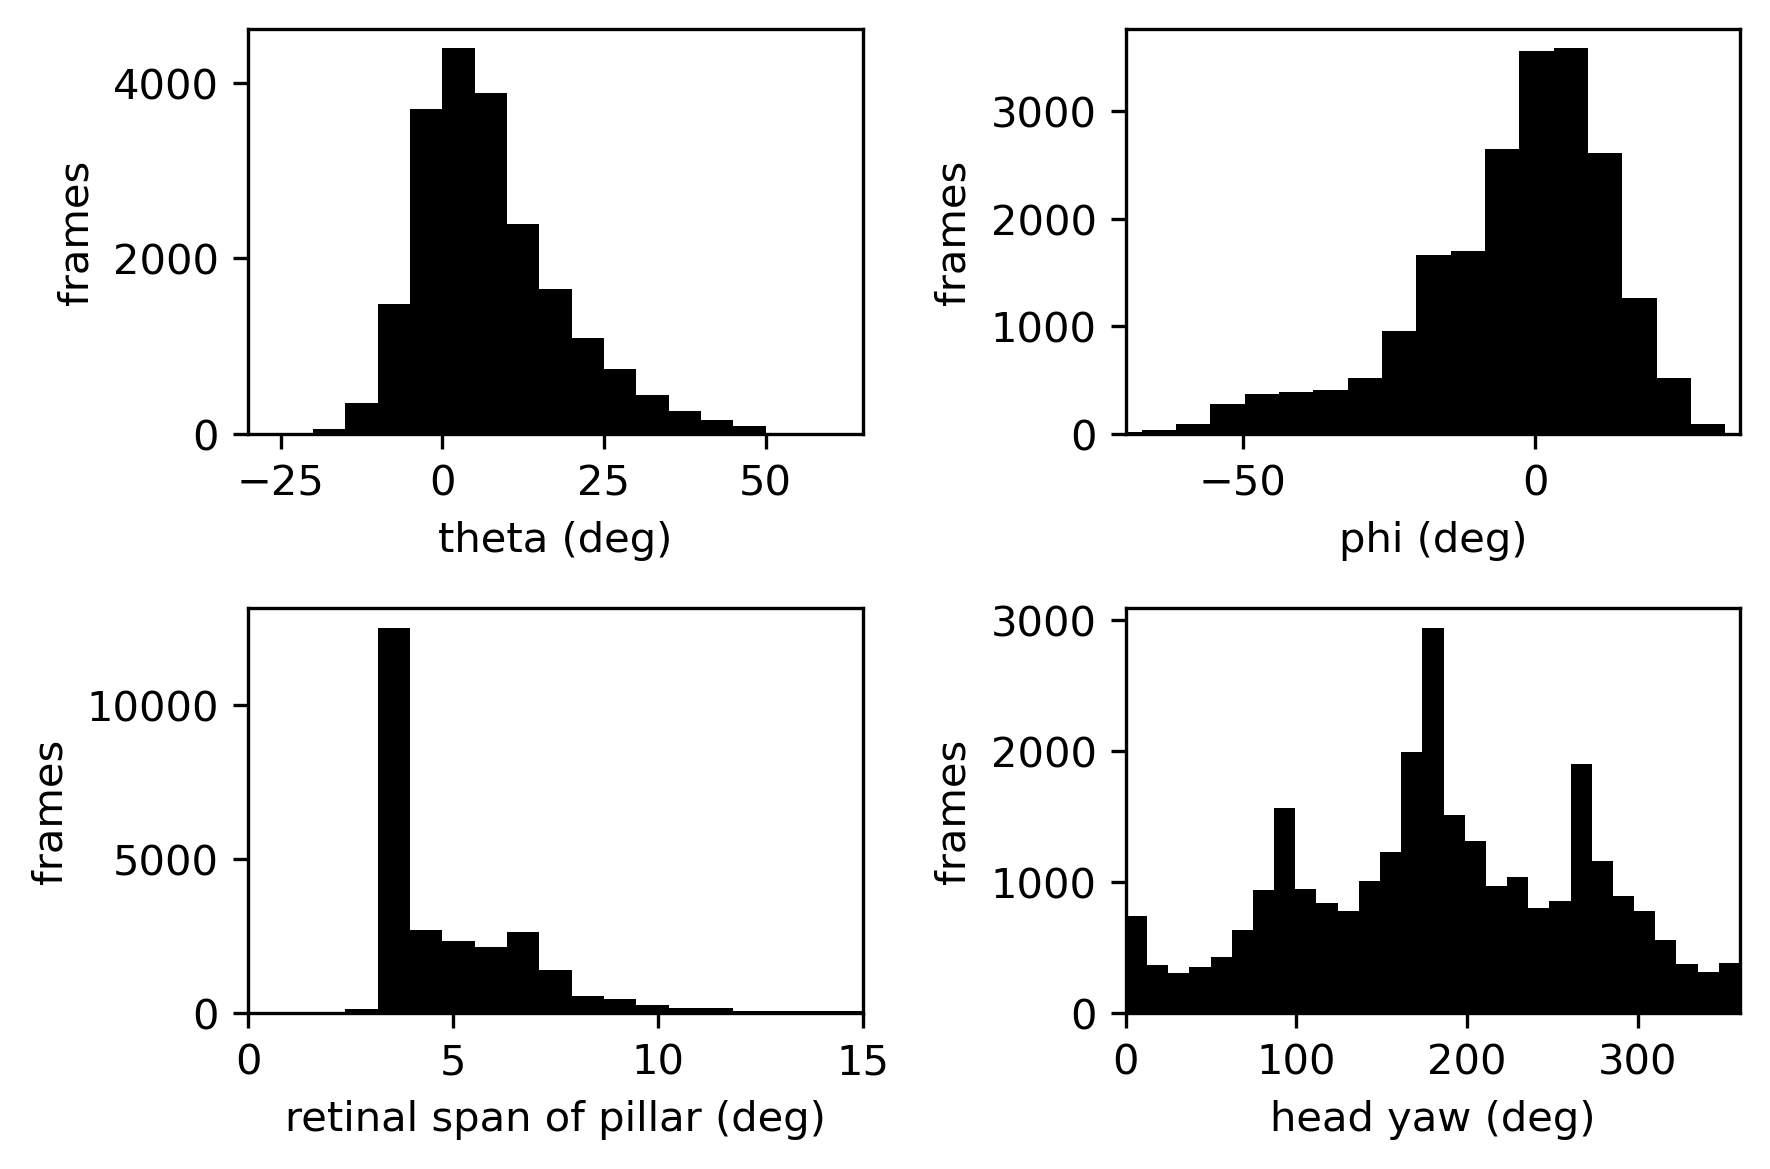

In [100]:
fig, axs = plt.subplots(2, 2, figsize=(6,4), dpi=300)
axs = axs.flatten()
axs[0].hist(np.rad2deg(theta), bins=np.linspace(-30,65,20), color='k')
axs[0].set_xlim([-30, 65])
axs[0].set_xlabel('theta (deg)')
axs[0].set_ylabel('frames')

axs[1].hist(np.rad2deg(phi), bins=20, color='k')
axs[1].set_xlim([-70,35])
axs[1].set_xlabel('phi (deg)')
axs[1].set_ylabel('frames')

axs[2].hist(np.rad2deg(angle_pillar_spans), bins=np.linspace(0, 15, 20), color='k')
axs[2].set_xlim([0,15])
axs[2].set_xlabel('retinal span of pillar (deg)')
axs[2].set_ylabel('frames')

axs[3].hist(yaw, bins=np.linspace(0, 360, 30), color='k')
axs[3].set_xlim([0,360])
axs[3].set_xlabel('head yaw (deg)')
axs[3].set_ylabel('frames')

fig.tight_layout()

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(6,4), dpi=300)
axs = axs.flatten()
axs[0].hist(dist_to_pillar / pxls2cm, bins=20, color='k')
axs[0].set_xlim([0, np.nanmax(dist_to_pillar / pxls2cm)])
axs[0].set_xlabel('theta (deg)')
axs[0].set_ylabel('frames')

axs[1].hist(np.rad2deg(angle_to_pillar)%360, bins=np.linspace(0, 360, 30), color='k')
axs[1].set_xlim([0,360])
axs[1].set_xlabel('phi (deg)')
axs[1].set_ylabel('frames')

# axs[2].hist(np.rad2deg(angle_pillar_spans), bins=np.linspace(0, 15, 20), color='k')
# axs[2].set_xlim([0,15])
# axs[2].set_xlabel('retinal span of pillar (deg)')
# axs[2].set_ylabel('frames')

# axs[3].hist(yaw, bins=np.linspace(0, 360, 30), color='k')
# axs[3].set_xlim([0,360])
# axs[3].set_xlabel('head yaw (deg)')
# axs[3].set_ylabel('frames')

fig.tight_layout()

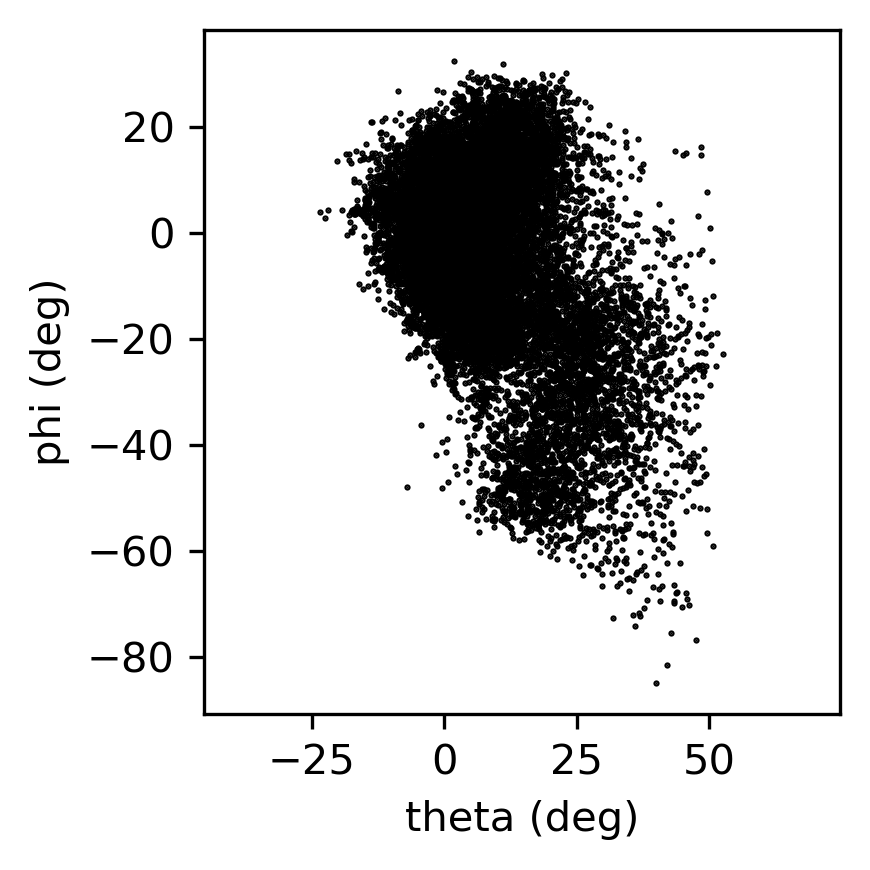

In [124]:
fig, ax = plt.subplots(1, 1, figsize=(3,3), dpi=300)
ax.plot(np.rad2deg(theta), np.rad2deg(phi), 'k.', ms=1)
ax.set_xlabel('theta (deg)')
ax.set_ylabel('phi (deg)')
ax.axis('equal')
fig.tight_layout()

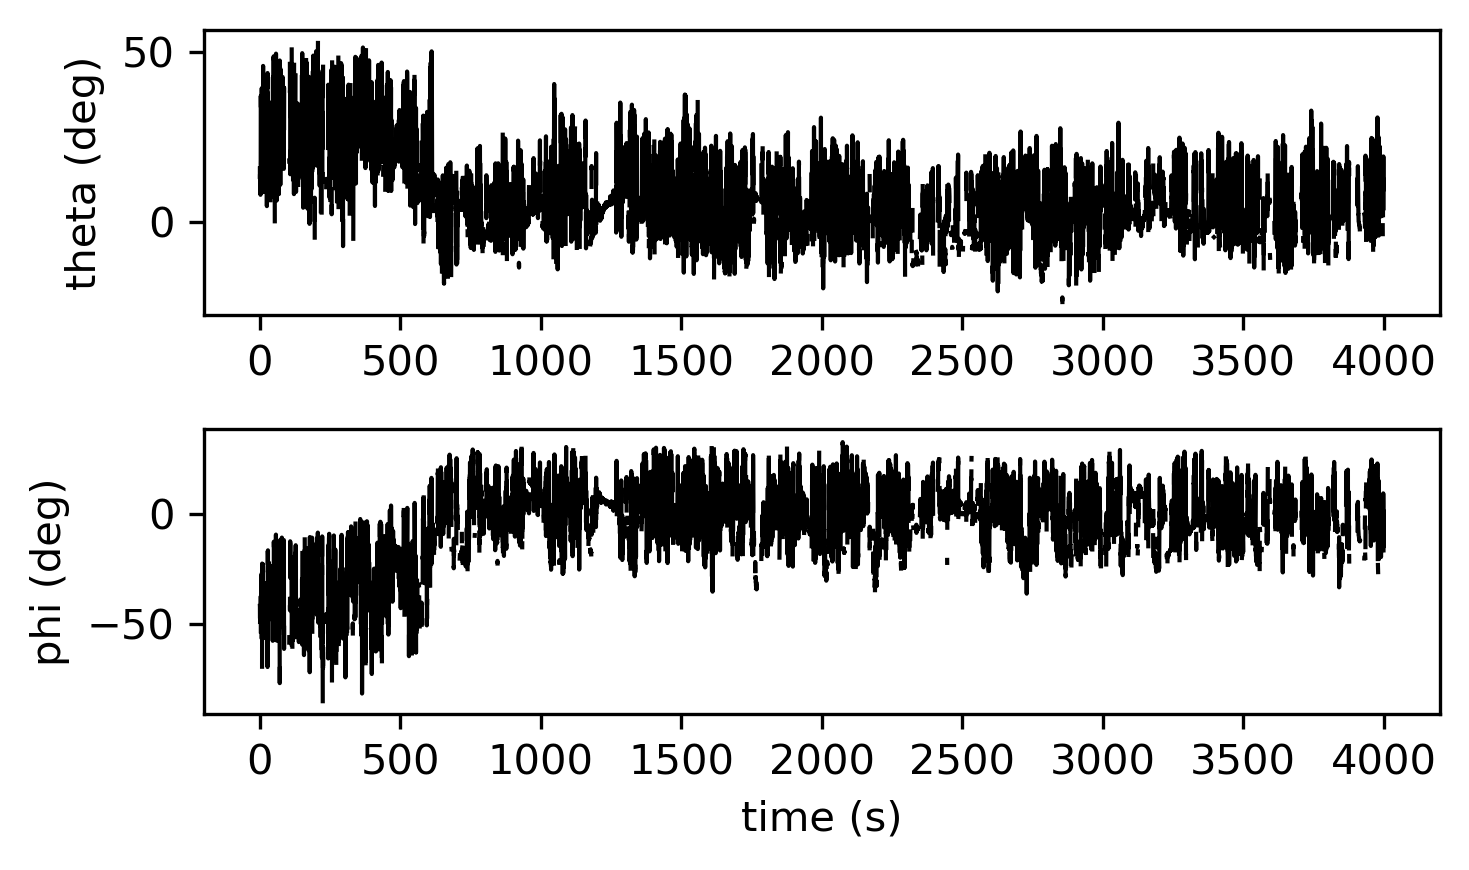

In [132]:
fig, [ax1,ax2] = plt.subplots(2,1, dpi=300, figsize=(5,3))
ax1.plot(twopT, np.rad2deg(theta), 'k-', lw=1)
ax2.plot(twopT, np.rad2deg(phi), 'k-', lw=1)
ax1.set_ylabel('theta (deg)')
ax2.set_ylabel('phi (deg)')
ax2.set_xlabel('time (s)')
fig.tight_layout()

In [ ]:
plt.figure(dpi=300, figsize=(8,4))
plt.plot(eyeT, theta_raw, lw=1)
plt.plot(twopT, theta+0.5, lw=1)
plt.xlim([3408, 3460])
plt.ylim([-.25,1])

In [ ]:
topdown_video = fm2p.pack_video_frames(r'K:\Mini2P\250220_DMM_DMM042_pillar\fm1\rec2_0001.mp4', dwnsmpl=0.5)

In [ ]:
f = 3410
plt.figure(dpi=300)
plt.imshow(topdown_video[f], cmap='gray')
plt.plot(top_x[f]/2, top_y[f]/2, 'r*')
# plt.arrow(top_x[f]/2, top_y[f]/2, dx= ,dy=)

In [ ]:
# frames = [3410, 2000, 6000, 10000]
frames = [500, 15000, 16000, 17000]

fig, axs = plt.subplots(2,2, dpi=300)
axs = axs.flatten()

for ax in range(4):
    axs[ax].imshow(topdown_video[frames[ax]], cmap='gray')
    axs[ax].set_title('f={} yaw={:.4}'.format(frames[ax], yaw[frames[ax]]))
    axs[ax].plot(top_x[frames[ax]]/2, top_y[frames[ax]]/2, 'r*')
    axs[ax].plot([top_x[frames[ax]]/2, (top_x[frames[ax]]/2)+30*np.cos(np.deg2rad(yaw[frames[ax]]))],
            [top_y[frames[ax]]/2,(top_y[frames[ax]]/2)+30*np.sin(np.deg2rad(yaw[frames[ax]]))],
            '-', linewidth=1, color='cyan')
    axs[ax].plot([top_x[frames[ax]]/2, (top_x[frames[ax]]/2)+30*np.cos(0)],
            [top_y[frames[ax]]/2,(top_y[frames[ax]]/2)+30*np.sin(0)],
            '-', linewidth=1, color='gold')
    
fig.tight_layout()

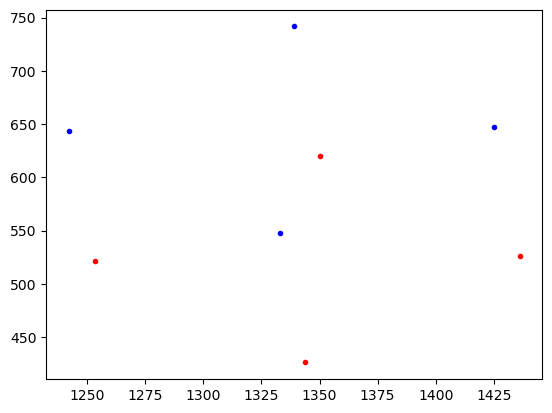

In [154]:
plt.plot(1343.9500732421875, 426.21319580078125, 'r.')
plt.plot(1350.1678466796875, 619.7420654296875, 'r.')
plt.plot(1253.3956298828125, 521.4739074707031, 'r.')
plt.plot(1436.0689697265625, 525.751953125, 'r.')

plt.plot(1332.8678221599364, 548.1179577055432, 'b.')
plt.plot(1339.0855955974364, 741.6468273344494, 'b.')
plt.plot(1242.3133788005614, 643.378669375465, 'b.')
plt.plot(1424.9867186443114, 647.6567150297619, 'b.')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import fm2p

Loading DLC 2.3.7...
DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)


c:\Users\dmartins\anaconda3\envs\fm1\lib\site-packages\oasis\functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


In [3]:
data = fm2p.read_h5(r'K:\Mini2P\250306_DMM_DMM038_pillar\fm1\250306_DMM_DMM038_fm_1_preproc.h5')

In [4]:
speed = data['speed'].copy()
np.shape(speed)

(12062,)

In [9]:
speed1 = np.append(speed, speed[-1])

In [10]:
speed1

array([nan, nan, nan, ..., nan, nan, nan])

In [22]:
data['oasis_spks'].shape

(57, 12063)

In [28]:
data['pupil_from_head'].shape

KeyError: 'pupil_from_head'

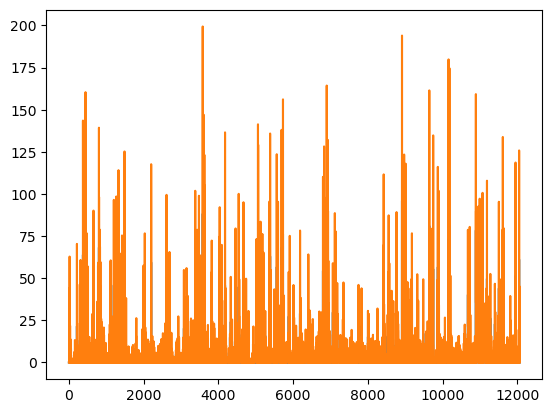

In [27]:
plt.plot(data['oasis_spks'][0,:])
plt.plot(data['s2p_spks'][0,:])

In [ ]:
np.nanpercentile(data['speed'])

In [30]:
[x for x in list(data.keys()) if 'head' in x]

['head_yaw', 'head_yaw_deg']

(array([543., 480., 363., 277., 272., 222., 231., 266., 257., 284., 277.,
        254., 236., 213., 264., 170., 172., 212., 182., 186., 152., 163.,
        125., 132., 123., 100., 104., 100.,  90.,  64.,  78.,  56.,  39.,
         39.,  38.,  25.,  15.,  11.,   8.,   9.,   7.,   6.,   7.,   4.,
          3.,   2.,   3.,   2.,   1.,   5.]),
 array([7.23571105e-02, 2.96553666e+00, 5.85871622e+00, 8.75189577e+00,
        1.16450753e+01, 1.45382549e+01, 1.74314344e+01, 2.03246140e+01,
        2.32177935e+01, 2.61109731e+01, 2.90041526e+01, 3.18973322e+01,
        3.47905118e+01, 3.76836913e+01, 4.05768709e+01, 4.34700504e+01,
        4.63632300e+01, 4.92564095e+01, 5.21495891e+01, 5.50427686e+01,
        5.79359482e+01, 6.08291277e+01, 6.37223073e+01, 6.66154869e+01,
        6.95086664e+01, 7.24018460e+01, 7.52950255e+01, 7.81882051e+01,
        8.10813846e+01, 8.39745642e+01, 8.68677437e+01, 8.97609233e+01,
        9.26541028e+01, 9.55472824e+01, 9.84404619e+01, 1.01333641e+02,
        1.

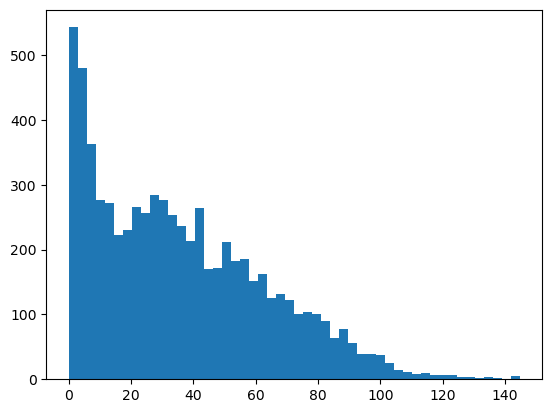

In [14]:
plt.hist(data['speed'], bins=50)

In [36]:
speed = data['speed']
speed = speed[~np.isnan(speed)]

In [37]:
len(data['speed'])

12062

In [38]:
len(speed)

6872

In [40]:
np.sum(speed>5.)/len(speed)

0.8672875436554133

In [46]:
lagstr = str(-2)
if '-' in lagstr:
    lagstr = lagstr.replace('-','neg')
else:
    lagstr = 'pos{}'.format(lagstr)
print(lagstr)

neg2
